## Data

In [1]:
# data
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import numpy as np
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [2]:
# process and normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
W, H = 32, 32
# x_train_flat = x_train.reshape((len(x_train), W, H, 3))
# x_test_flat = x_test.reshape((len(x_test), W, H, 3))
x_train.shape, x_test.shape #3 x_train_flat.shape, x_test_flat.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [23]:
# labels
labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']
len(labels)

10

## U-net

Use [TensorSpace JS](https://tensorspace.org/html/playground/index.html) to visualzie convolutional operation if you missed the lecture.

### BatchNormalization

Batch Normalization is indeed one of the major breakthroughs in the field of deep learning, and it is also one of the hot topics discussed by researchers in recent years. Batch Normalization is a widely used technique that makes training faster and more stable, and has become one of the most influential methods.

#### How it works?

Batch Normalization normalizes the output of the previous output layer by subtracting the empirical average value from the batch and dividing it by the empirical standard deviation. This will make the data look like a Gaussian distribution:
$$\bar{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
where the arguments/parameters, $\mu$ and $\sigma^2$, in the formula are the mean and standard deviation for that batch ($B$ indiates which batch it is, i.e. $B = 1, 2, 3, ...$).

Benefits of using batch normalization:
- Faster convergence.
- Reduce the importance of the initial weight.
- Robust hyperparameters.
- Need less data for generalization.

Sample graphical evidence below shows the strength of the batch normalization
<p align='center'><img src='https://miro.medium.com/max/805/0*6gqi9ePQNZIfjmm6' width=600></img></p>

Problems of using batch normalization:
- Unstable when using small batch size
- Lead to an increase in training time
- Different results during training and inference

Source: [1](https://medium.com/@wenzhao.li1989/the-curse-of-batch-normalization-4f1a7f35cd55), [2](https://towardsdatascience.com/implementing-batch-normalization-in-python-a044b0369567)

### Conv2D and Conv2DTranspose

<p align='center'><img src='https://i.stack.imgur.com/o5TBk.png' width=600></img></p>

How does Conv2DTranspose work?

<p align='center'><img src='https://i.stack.imgur.com/SEJ5q.png' width=600></img></p>

$$
\begin{bmatrix}
1 & 1 \\
1 & 1 \\
\end{bmatrix}
⋆
\begin{bmatrix}
1 & 1 \\
1 & 1 \\
\end{bmatrix}
\rightarrow
\begin{bmatrix}
1 & 1+1 & 1 \\
1+1 & 1+1+1+1 & 1+1 \\
1 & 1+1 & 1 \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1 \\
\end{bmatrix}
$$

### U-net Model

<p align='center'><img src='https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png' width=600></img></p>

U-net was proposed by Olaf Ronneberger, Philipp Fischer, and Thomas Brox (2015). In their paper, they present the following abstract.

There is large consent that successful training of deep networks requires many thousand annotated training samples. In this paper, we present a network and training strategy that relies on the strong use of data augmentation to use the available annotated samples more efficiently. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. We show that such a network can be trained end-to-end from very few images and outperforms the prior best method (a sliding-window
convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. Using the same network trained on transmitted light microscopy images (phase contrast and DIC) we won the ISBI cell tracking challenge 2015 in these categories by a large margin. Moreover, the network is fast. Segmentation of a 512x512 image takes less than a second on a recent GPU. The full implementation (based on Caffe) and the trained networks are available at [here](http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net).

Source: [paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [3]:
# define unet
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

### Set Args

In [4]:
# define
input_shape = (W, H, 3)
model = build_unet(input_shape)

In [5]:
# summary
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

### Customized Loss: IOU, Dice

Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset. We often see this evaluation metric used in object detection.

<p align='center'><img src='https://929687.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=1&strip=1&webp=1' width=300></img></src>

The Sørensen–Dice coefficient (see below for other names) is a statistic used to gauge the similarity of two samples. Sørensen's original formula was intended to be applied to discrete data. Given two sets, X and Y, it is defined as

$$\text{DSC} = \frac{2|X \cap Y|}{|X| + |Y|}$$

When applied to Boolean data, using the definition of true positive (TP), false positive (FP), and false negative (FN), it can be written as
$$\text{DSC} = \frac{2\text{TP}}{2\text{TP} + \text{FP} + \text{FN}}$$

Interpretation:
- Small overlap implies poor performance and hence smaller IoU coefficient;
- Large overlap implies good performance and hence larger IoU coefficient.

<p align='center'><img src='https://upload.wikimedia.org/wikipedia/commons/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png' width=400></img></p>

For more information, see [here](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).

In [6]:
# backend
from keras import backend as K

# dice
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

# iou
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [7]:
# customized optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-6,
    decay_steps=10000,
    decay_rate=0.6)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [8]:
# compile
model.compile(
    ## Your Changes Start Here ##
    # optimizer: https://keras.io/api/optimizers/
    # loss: https://keras.io/api/losses/
    optimizer=optimizer,
    loss=dice_loss,
    metrics=[iou_coef,'accuracy']
    ## Your Changes Ends Here ##
)

This assumes you have GPU set up in Colab. Please check using "Runtime" > "Change Run Type" > "Hardware Accelerator": Select GPU.

In [9]:
# load gpu
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
# model fitting
batch_size=30
x_train.shape[0] // batch_size

1666

Text(0.5, 1.0, 'in binary form')

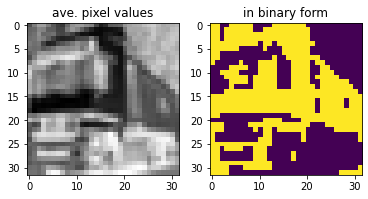

In [11]:
# average value of all 3 pixels for a 2D image
plt.subplot(1, 2, 1)
plt.imshow(np.mean(x_train[1], 2), cmap='binary')
plt.title('ave. pixel values')
plt.subplot(1, 2, 2)
plt.imshow((np.mean(x_train[1], 2) > 0.5).astype(int))
plt.title('in binary form')

### Create Masks

In [12]:
# progress bar
from tqdm import tqdm

In [13]:
# create mask
## train
m_train = []
for i in tqdm(range(len(x_train))):
    m_train.append((np.mean(x_train[i], 2) > 0.5).astype(int))

## test
m_test = []
for i in tqdm(range(len(x_test))):
    m_test.append((np.mean(x_test[i], 2) > 0.5).astype(int))

# convert to array
m_train = np.asarray(m_train)
m_test = np.asarray(m_test)

# check
m_train.shape, m_test.shape

100%|██████████| 10000/10000 [00:00<00:00, 31444.86it/s]


((50000, 32, 32), (10000, 32, 32))

In [14]:
# display image shape again
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [15]:
# train
with tf.device('/device:GPU:0'):
    history = model.fit(
        x_train, # X: the data the model use to learn
        m_train.reshape((len(m_train), W, H, 1)), # Y: the target the model try to predict
        
        ## Your Changes Start Here ##
        # there is a sweet spot, you don't want to overfit, but you also want to make sure your model learned something
        validation_split=0.2, # a ratio of percentage that the model uses for validating
        # validation_data = (X_test, m_test_flatten),
        batch_size=x_train.shape[0] // batch_size,
        epochs=500
        ## Your Changes Ends Here ##
    )

Epoch 1/500
25/25 [==============================] - 22s 248ms/step - loss: 0.4909 - iou_coef: 0.2842 - accuracy: 0.3960 - val_loss: 0.4886 - val_iou_coef: 0.2937 - val_accuracy: 0.2484
Epoch 2/500
25/25 [==============================] - 5s 193ms/step - loss: 0.4899 - iou_coef: 0.2886 - accuracy: 0.4064 - val_loss: 0.4886 - val_iou_coef: 0.2947 - val_accuracy: 0.2893
Epoch 3/500
25/25 [==============================] - 5s 193ms/step - loss: 0.4888 - iou_coef: 0.2903 - accuracy: 0.4168 - val_loss: 0.4880 - val_iou_coef: 0.2976 - val_accuracy: 0.3636
Epoch 4/500
25/25 [==============================] - 5s 204ms/step - loss: 0.4878 - iou_coef: 0.2939 - accuracy: 0.4273 - val_loss: 0.4873 - val_iou_coef: 0.3009 - val_accuracy: 0.3964
Epoch 5/500
25/25 [==============================] - 5s 194ms/step - loss: 0.4867 - iou_coef: 0.2981 - accuracy: 0.4379 - val_loss: 0.4866 - val_iou_coef: 0.3041 - val_accuracy: 0.4159
Epoch 6/500
25/25 [==============================] - 5s 203ms/step - loss:

### Training Path

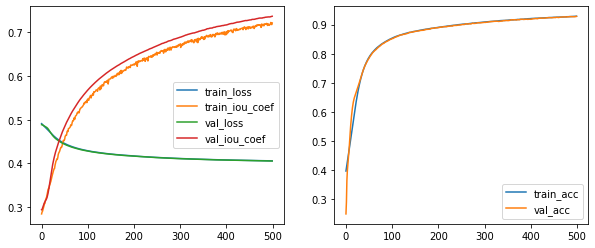

In [16]:
# plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_iou_coef'])
plt.legend(['train_loss', 'train_iou_coef', 'val_loss', 'val_iou_coef'])
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

### Evaluation

In [22]:
# evaluate
a, b, c = model.evaluate(x_test, m_test.reshape((10000, 32, 32, 1)))
print('loss=',a)
print('iou_coef=',b)
print('acc=',c)

313/313 [==============================] - 2s 8ms/step - loss: 0.4038 - iou_coef: 0.7222 - accuracy: 0.9288
loss= 0.40376847982406616
iou_coef= 0.7222476005554199
acc= 0.9287558794021606


### Prediction

In [18]:
# predict
m_test_pred_ = model.predict(x_test)
m_test_pred_.shape

(10000, 32, 32, 1)

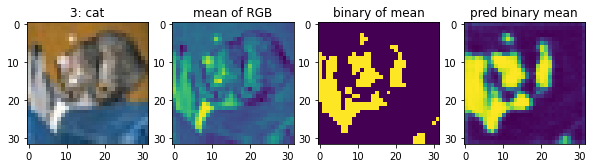

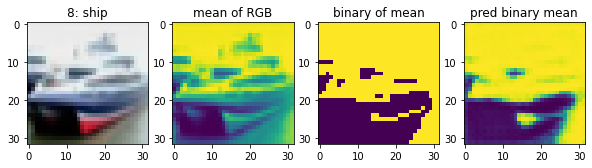

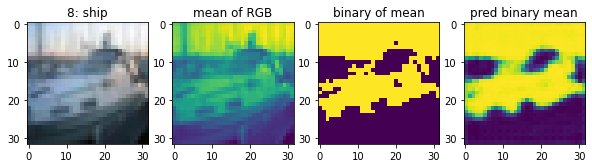

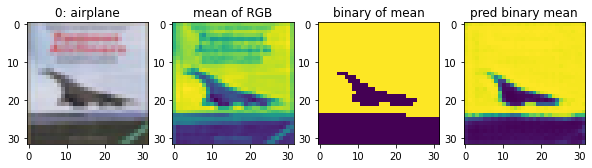

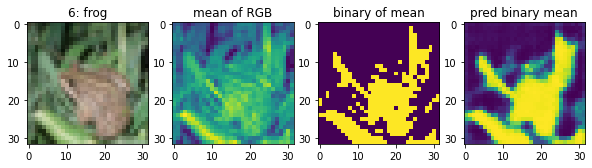

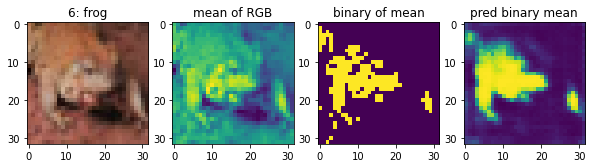

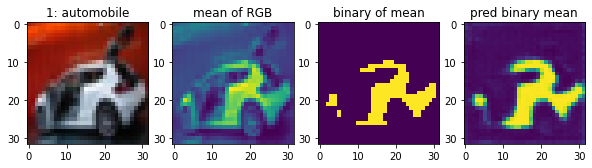

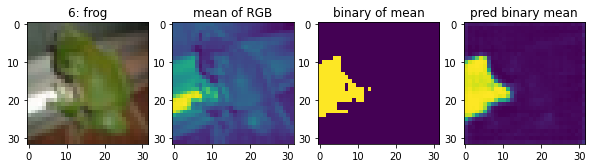

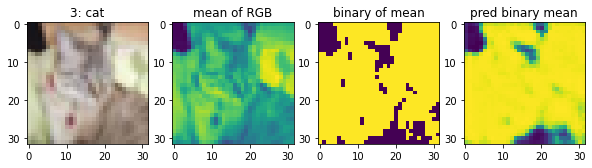

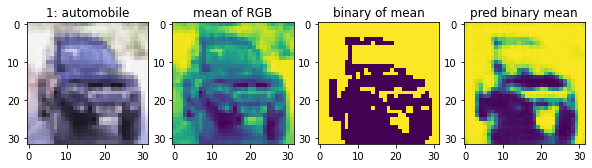

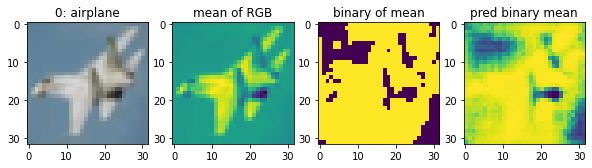

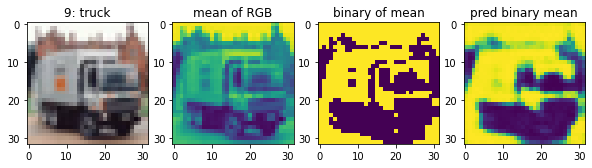

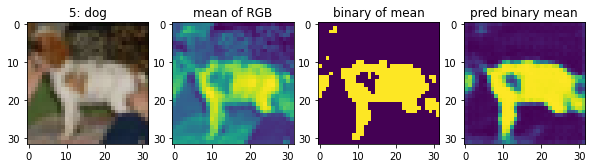

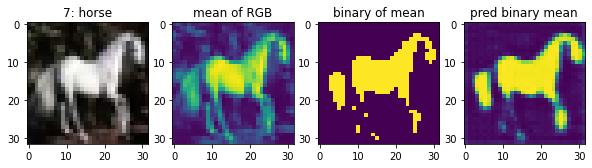

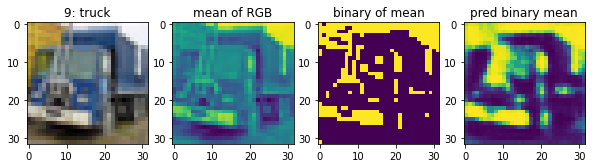

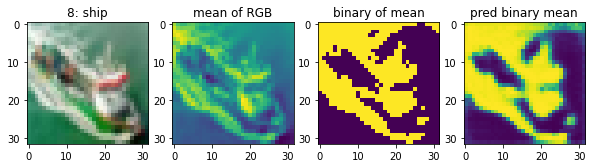

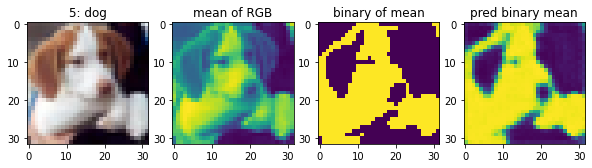

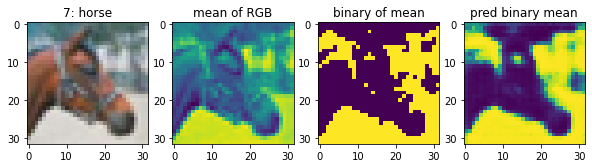

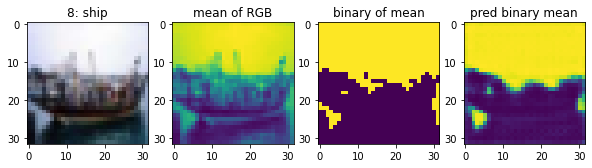

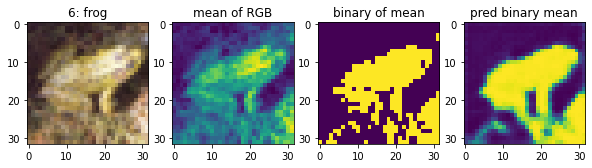

In [35]:
# plot
for i in range(20):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(x_test[i])
    plt.title(str(y_test[i][0])+': '+str(labels[list(y_test[i])[0]]))
    plt.subplot(1, 4, 2)
    plt.imshow(np.mean(x_test[i], 2))
    plt.title('mean of RGB')
    plt.subplot(1, 4, 3)
    plt.imshow(m_test[i])
    plt.title('binary of mean')
    plt.subplot(1, 4, 4)
    plt.imshow(m_test_pred_[i].reshape((W, H)))
    plt.title('pred binary mean')
    plt.show()

Investigation ends here.